# Using BERT to quantify the predictability of writing style

Transformer-based models of language such as BERT have been used create state-of-the-art models for a wide range of NLP tasks over the past few years. 
BERT's next-sentence prediction's capability have recently been used to <a href='https://tedunderwood.com/2020/07/05/how-predictable-is-fiction/'>assess the predictability of fiction.</a> 
This notebook attempts to use another task that BERT can be trained on, masked language modeling, to assess the predictability of style within a single sentence.

In lay language, masked language modeling can be described as a fill-in-the-blanks task. A model is given a sentence, each token in the sentence is hidden and the model made to predict it using the surrounding context words. The idea is that we can use the probabilities generated by such a model to assess how predictable the style of a sentence is. For instance, in the following English language sentence:

    His hair as gold as the sun , his eyes blue like the [MASK].

BERT (English) can predict `sky` with a 27.1% probability. But in the this sentence:

    `The [MASK] above the port was the color of television, tuned to a dead channel`

the probability of `sky` falls much lower, with BERT instead giving tokens such as `screen`, `window` or `panel` the highest probabilities - since the comparison to television makes the presence of the word less predictable. In short, BERT is better at predicting boilerplate than original writing. 

<br>
<br>

I would like to extend this beyond the scope of a single word and onto the scale of a complete sentence, i.e. evaluating a sentence's predictability. This approach makes sense because the way BERT computes probability would reflect a couple of things typically associated with literary originality: 
- the "preciosity" of a word (given two synonyms, the rarer one will receive a lower probability)
- the unexpectedness of comparison and literary or poetic language (we might say, in structuralist terms, that BERT's probabilities are computed following paradigmatic (predicting a word over others) and syntagmatic (based on its context) axes, whose order are subverted by the "poetic function" of language)

This predictability score could then be used as a metric for literary creativity. Being able to quantify such a value would be interesting for literary history and comparative literature, for instance if we were to compare it against signs of literary recognition (literary prizes, publication in prestigious or non-prestigious publishing houses...), enabling us to evaluate how much a certain literary culture values conformity over creativity (or vice-versa) at a certain point in time.

<br>
<br>

The insight that a language model can be used to assert how "common" the style of sentence is not entirely new. The scoring of sentences by language models, known as <a href='https://en.wikipedia.org/wiki/Perplexity#:~:text=of%20size%20N).-,Perplexity%20per%20word,over%20entire%20sentences%20or%20texts.'>perplexity</a> has been used in tasks such as automatic translation to rate which of the outputs of a model might be the most well-formed sentence in a particular target language. The main differences with our case are that:
1. Traditional language models are sequential, working from left to right. They do not use the whole sentence as context to predict a single word. Some models combine left-to-right models with right-to-left models, but the process is still different from BERT since the probability is computed from the knowledge of what comes before only and what comes after only, not on the entire context.
2. Working with literary texts, we can assume that the sentences we will feed into the model will be generally gramatically correct (or intentionally incorrect). This allows us to be more selective in the categories of word we want to evaluate, skipping pronouns or particles (*still requires further investigation*).

Regarding point 1, BERT gives us an advantage over sequential language models. Because it is bi-directional, it allows us to consider the context on both sides of a word, which is closer to how a human reader would assert the unexpectedness of a single word within a sentence. 

<a href=' https://arxiv.org/pdf/1906.00363.pdf'>Wang et al (2019)</a> averaged the probabilities of the tokens in a sentence ($\prod_{i=1}^{n}p(w_{i}|w_{1},...,w_{i-1},w_{i+1},...,w_{n}))^{-1/n} $) to predict whether a sentence is non-sensical or not - similar to how the perplexity score is used by sequential language models. 

<a href='https://assets.amazon.science/cc/54/980cb7d74f93849b49b9d5c42466/masked-language-model-scoring.pdf'>Salazar et al (2020)</a> develop a measure of "pseudo-perplexity" to rank sentences with BERT by used log probabilities. This pseudo-perplexity is defined as: $exp(-1/n\sum_{i=1}^{n}log(p(w_{i}|w_{1},...,w_{i-1},w_{i+1},...,w_{n})))) $. This is the measure we'll rely on. 

Point 2 is tied to language specific issues, adressed in the "Language specifics" section below.

### Issues with the metric

Perplexity score is traditionally used to rank different versions of the *same sentence* when generating text with a language model. Because the variation between such sentences is limited, it seems that the behavior of the perplexity score across widely different sentences (as we are doing here) is still unexplored. 
Differences in perplexity scores are minimal. Probabilities for every word tend to be low, but the absolute value hardly matters, the differential from the next word's probability is important. The difference in the mean values of the sentences of our corpus will likewise be tiny, statistical significance may be achieved because of large sample size, but whether that indeed represents an actual effect is less certain.

### Language specifics

Working with Korean and with literary texts, the above formula seems to present some limitations. For instance, Korean can mark the object of a verb with a specific particle (를/을). Predicting this particle being present between a noun and a verb is not hard (tokenizers such as BERT's separate it from the noun to which it would be attached). Therefore the token would be assigned a high probability. However, case particles can and are often omitted depending on context and individual preferences. Including it in the scoring of a sentence might therefore introduce bias, ranking writers who use it extensively as less creative than writers who use it more sparingly. On the other hand, as noted in Point 2 above, we are not interested in evaluating the grammatical correctness of a sentence, and therefore including case particles bring little additional information to our metric. The same is true of punctuation, pronouns, prepositions... We therefore opt to restrict the model to predicting masked nouns, adjectives and verbs (all tokens are still nonetheless used as context).

### Technical specifics

This approach requires us to be able to control the tokenization process because we want to be able to select the words which we will mask for prediction. Because most implementations of BERT uses a type of tokenizer that works splitting more complex words into smaller words to retain a small vocabulary size. This choice of tokenizing method is a powerful way to deal with out-of-vocabulary words (they will be split into smaller, in-vocabulary pieces). 

To address this issue, I've pre-tokenized the training data used during fine-tuning. I then train a new tokenizer with a large dictionary size and use its vocabulary to update the tokenizer's vocabulary of the base BERT model used for fine-tuning. (see <a href='https://github.com/digitalprk/sih_notebooks/blob/master/run_language_modeling.py'>here</a>). (Note that this extra step would not be needed if we did not want to exclude certain grammatical categories: we could simply use the mean of the probabilities of the differents parts of a word that was split as the probability of that word).

The base model used was <a href='https://github.com/SKTBrain/KoBERT'>KoBERT</a>, a BERT model trained by the SK Telecom team on South Korean language data. The model was fine-tuned on a small (1.6Gb) corpus of North Korean language data comprising novels, literary journals, newspapers, non-fiction books and the complete works of Kim Il-Sung and Kim Jong-Il.

### Data

30000 Sentences were extracted from four types of sources:
1. The Korean Central News Agency (the North Korean state's press agency)
2. Novels by prestigious writers (recognized for their literary excellence with a state sanctioned distinction)
3. Novels by "regular" writers
4. Canonical novels (fictional accounts of the lives of Kim Il-Sung and Kim Jong-Il held to be of the highest literary quality). 
5. Collections of poetry

None of the novels or press releases used were present in the corpus used to fine-tune the model. However, the corpus did contain similar content (literary sources and press releases for different years). All content used came from the years 1967 - 2018.

### Results

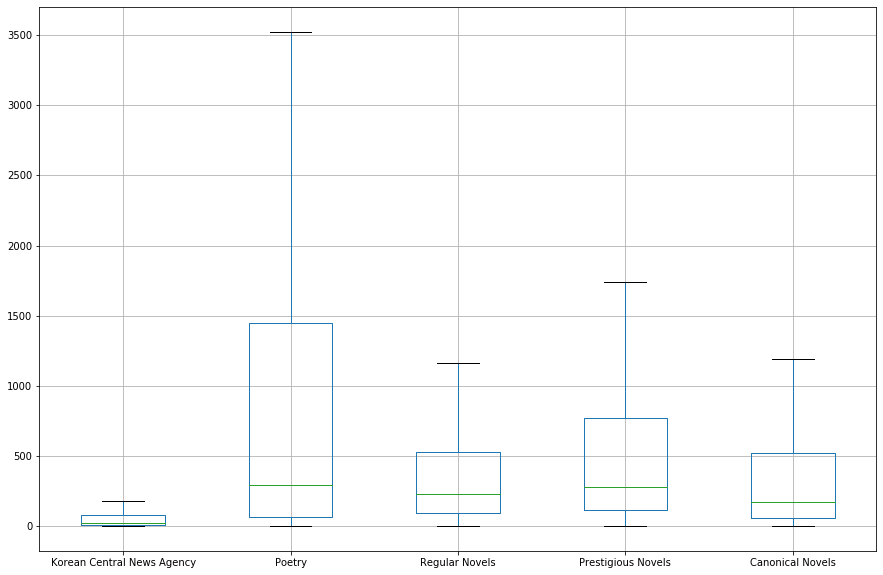

In [369]:
%matplotlib inline
df.boxplot(figsize = (15, 10), showfliers=False)

In [370]:
df.describe()

,Korean Central News Agency,Poetry,Regular Novels,Prestigious Novels,Canonical Novels
count,500.00000,500.00000,500.00000,500.00000,500.00000
mean,107.17284,2763.12852,639.56982,795.15111,550.25259
std,429.92459,10193.23875,2669.37321,1643.41812,1306.04022
min,1.38257,1.39690,3.12559,1.41605,1.53810
25%,8.24915,63.01481,91.16091,112.68442,60.33604
50%,23.81456,291.19931,226.82967,278.93782,172.59180
75%,78.56058,1447.97320,527.92088,770.02449,523.35228
max,8480.83891,155184.30224,56007.44665,17676.74928,14217.40903


In [371]:
from scipy import stats
from itertools import combinations
for a, b in list(combinations(df.columns, 2)):
    print(f'{a} : {b}')
    print(stats.ttest_ind(df[a],df[b]))

Korean Central News Agency : Poetry
Ttest_indResult(statistic=-5.821135136802824, pvalue=7.872310028052302e-09)
Korean Central News Agency : Regular Novels
Ttest_indResult(statistic=-4.40301697589195, pvalue=1.1826569782035264e-05)
Korean Central News Agency : Prestigious Novels
Ttest_indResult(statistic=-9.05601801711839, pvalue=6.954975641461455e-19)
Korean Central News Agency : Canonical Novels
Ttest_indResult(statistic=-7.205594299990466, pvalue=1.1383182892405891e-12)
Poetry : Regular Novels
Ttest_indResult(statistic=4.50644069210665, pvalue=7.37239483806634e-06)
Poetry : Prestigious Novels
Ttest_indResult(statistic=4.262069426326252, pvalue=2.2173122779891363e-05)
Poetry : Canonical Novels
Ttest_indResult(statistic=4.814974060003569, pvalue=1.7000234339050913e-06)
Regular Novels : Prestigious Novels
Ttest_indResult(statistic=-1.1098024569459393, pvalue=0.26735149574031053)
Regular Novels : Canonical Novels
Ttest_indResult(statistic=0.6720600664430709, pvalue=0.5017010062218142)
P

### Comments

- The method seems to be at least working for discriminating between discursive genres (press writing, fiction, poetry)
- Poetry is much less predictable than prose fiction. The median is lower somewhat similar to that of prose however, indicating that the very predictable verses are pulling the average down.
- The method shows less significant differences between subgroups of fiction writing. This may be because there's none and all rely, on average, on the same amount of boilerplate. Comparisons between individual writers might be more meaningful. Other possibilities: issues with the fine-tuned model, wrong assumption that the method can be used indiscriminately on any sentence of a text (need to filter at least dialogue, or select for metaphoric sentences with metaphor detection, wrong assumption that the method actually works as intended...)

<hr>

## Code

In [213]:
from transformers import AutoModelWithLMHead, AutoTokenizer
import torch
import logging
import numpy as np
import pickle

logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

tokenizer = AutoTokenizer.from_pretrained("../jobert")
model = AutoModelWithLMHead.from_pretrained("../jobert")

I0930 12:14:43.295866 14160 configuration_utils.py:262] loading configuration file ../jobert\config.json
I0930 12:14:43.297861 14160 configuration_utils.py:300] Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "type_vocab_size": 2,
  "vocab_size": 20839
}

I0930 12:14:43.298859 14160 tokenization_utils_base.py:1167] Model name '../jobert' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-

In [214]:
from konlpy.tag import Komoran
komoran = Komoran()

In [361]:
def compute_word_proba(sequence, word):
    global model, tokenizer
    input_ids = tokenizer.encode(sequence, return_tensors="pt")
    mask_token_index = torch.where(input_ids == tokenizer.mask_token_id)[1]
    token_logits = model(input_ids)[0]
    mask_token_logits = token_logits[0, mask_token_index, :]
    mask_token_logits = torch.softmax(mask_token_logits, dim=1)
    sought_after_token = word
    sought_after_token_id = tokenizer.encode(sought_after_token, add_special_tokens=False, add_prefix_space=True)[0]
    token_score = mask_token_logits[:, sought_after_token_id]
    return token_score.detach().numpy()[0]

def compute_word_by_word_proba(sequence, tokenized=False):
    global tokenizer
    global komoran
    pos_filter = ['VV', 'VA', 'NNG', 'NNP', 'MAG', 'NA', 'SN', 'NR', 'XR'] # we only want to predict verbs, nouns and adjectives
    word_dict = {}
    if not tokenized:
        tokenized_sequence = komoran.pos(sequence)
    else:
        tokenized_sequence = sequence
    sequence = ' '.join([token for token, pos in tokenized_sequence])
    for token, pos in tokenized_sequence:
        #print(token, pos)
        if pos in pos_filter:
            masked_sequence = sequence.replace(token, tokenizer.mask_token)
            word_dict[token] = compute_word_proba(masked_sequence, token)
    return word_dict

def compute_word_by_word_proba_no_filter(sequence, tokenized=False):
    global tokenizer
    global komoran
    word_dict = {}
    if not tokenized:
        tokenized_sequence = komoran.pos(sequence)
    else:
        tokenized_sequence = sequence
    sequence = ' '.join([token for token, pos in tokenized_sequence])
    for token, pos in tokenized_sequence:
        masked_sequence = sequence.replace(token, tokenizer.mask_token)
        word_dict[token] = compute_word_proba(masked_sequence, token)
    return word_dict

def compute_sentence_pseudo_perplexity_no_filter(sentence, tokenized=False):
    return np.exp(-1*(np.mean([np.log(p) for p in list(compute_word_by_word_proba_no_filter(sentence, tokenized).values())])))

def geometric_mean(series):
    return np.array(series, dtype=np.float64).prod()**(1.0/len(series))

def compute_sentence_score(sentence, tokenized=False):
    return geometric_mean(list(compute_word_by_word_proba(sentence, tokenized).values()))

def compute_sentence_pseudo_log_likelihood(sentence, tokenized=False):
    return abs(np.mean([np.log(p) for p in list(compute_word_by_word_proba(sentence, tokenized).values())]))

def compute_sentence_pseudo_perplexity(sentence, tokenized=False):
    return np.exp(-1*(np.mean([np.log(p) for p in list(compute_word_by_word_proba(sentence, tokenized).values())])))

In [326]:
seq = '젊은이들은 조심히 김진수의 낯빛을 살피며 한숨을 삼켰다.'
print(compute_sentence_pseudo_perplexity(seq))
seq2 = '젊은이들은 조심히 김진수의 낯빛을 살피며 음식을 삼켰다.'
print(compute_sentence_pseudo_perplexity(seq2))
seq3 = '젊은이들은 조심히 김진수의 낯빛을 살피며 도서관을 삼켰다.'
print(compute_sentence_pseudo_perplexity(seq3))

1.1840551468688112
1.1708098991240796
1.1493132982953256


In [227]:
compute_sentence_pseudo_perplexity(komoran.pos(seq3), True)

1.1493132982953256

In [319]:
compute_sentence_pseudo_perplexity_no_filter('천만에, 그런 일은 있을수 없습니다.')

1.4463220923521731

In [353]:
compute_sentence_pseudo_perplexity('보선구도 그렇구 검차구도 그렇고 다 그 모양입니다.')

1.1363530048423305

In [354]:
sentence = '보선구도 그렇구 검차구도 그렇고 다 그 모양입니다.'

In [357]:
np.mean([np.log(p) for p in list(compute_word_by_word_proba(sentence, False).values())])

-7.823256

In [359]:
np.exp(-1*(np.mean([np.log(p) for p in list(compute_word_by_word_proba(sentence, False).values())])))

2498.0257922131314

In [358]:
np.exp(-1*_)

2498.0257922131314

In [362]:
compute_sentence_pseudo_perplexity(sentence, False)

2498.0257922131314

In [349]:
probs = list(compute_word_by_word_proba('보선구도 그렇구 검차구도 그렇고 다 그 모양입니다.').values())
probs

[0.0002094706,
 2.4500273e-06,
 0.00021607347,
 0.0001972401,
 0.0040173316,
 0.046837114]

In [365]:
compute_sentence_pseudo_perplexity('미국인이 하바드대학에 추천해서 1달후에 떠난다고 하다가 전쟁이 발발하여 눌러있었습니다.')

1528.9491509155284

In [342]:
probs = list(compute_word_by_word_proba('위대한 수령 김일성동지는').values())
probs

[0.99197704, 0.997336, 0.9904811, 0.98898405]

In [331]:
np.mean(list(compute_word_by_word_proba('위대한 수령 김일성동지는').values()))

0.99219453

In [350]:
x = [np.log(_) for _ in probs]
x

[-8.470927, -12.919412, -8.439892, -8.531089, -5.5171375, -3.0610793]

In [351]:
np.mean(x)

-7.823256

In [352]:
np.exp(-1*np.mean(x))

2498.0257922131314

### With a pre-processed corpus

In [257]:
import pickle
with open('processed_corpus.pkl', 'rb') as fp:
    processed_corpus = pickle.load(fp)

In [366]:
final_results = {}
for corpus in processed_corpus.keys():
    scores = []
    print(corpus)
    for tokenized_sentence in tqdm(processed_corpus[corpus]['tokens'][:500]):
        try:
            score = compute_sentence_pseudo_perplexity(tokenized_sentence, tokenized=True)
            scores.append(score)
        except Exception as e:
            scores.append(np.mean(scores))
            print("Error:", sentence)
            print(e)
            pass
    final_results[corpus] = scores

Korean Central News Agency




  0%|                                                                                                                                                                                 | 0/500 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                        | 1/500 [00:00<04:36,  1.81it/s]

  0%|▋                                                                                                                                                                        | 2/500 [00:06<18:52,  2.27s/it]

  1%|█                                                                                                                                                                        | 3/500 [00:09<20:33,  2.48s/it]

  1%|█▎                                                                                                                                                               

  8%|█████████████                                                                                                                                                           | 39/500 [01:24<13:47,  1.80s/it]

  8%|█████████████▍                                                                                                                                                          | 40/500 [01:26<14:15,  1.86s/it]

  8%|█████████████▊                                                                                                                                                          | 41/500 [01:28<13:56,  1.82s/it]

  8%|██████████████                                                                                                                                                          | 42/500 [01:29<12:26,  1.63s/it]

  9%|██████████████▍                                                                                                                                                    

 16%|██████████████████████████▏                                                                                                                                             | 78/500 [02:34<10:02,  1.43s/it]

 16%|██████████████████████████▌                                                                                                                                             | 79/500 [02:37<12:56,  1.84s/it]

 16%|██████████████████████████▉                                                                                                                                             | 80/500 [02:39<11:36,  1.66s/it]

 16%|███████████████████████████▏                                                                                                                                            | 81/500 [02:40<10:56,  1.57s/it]

 16%|███████████████████████████▌                                                                                                                                       

 23%|███████████████████████████████████████                                                                                                                                | 117/500 [03:48<13:03,  2.05s/it]

 24%|███████████████████████████████████████▍                                                                                                                               | 118/500 [03:49<11:18,  1.78s/it]

 24%|███████████████████████████████████████▋                                                                                                                               | 119/500 [03:52<13:18,  2.10s/it]

 24%|████████████████████████████████████████                                                                                                                               | 120/500 [03:52<09:59,  1.58s/it]

 24%|████████████████████████████████████████▍                                                                                                                          

 31%|████████████████████████████████████████████████████                                                                                                                   | 156/500 [04:43<09:50,  1.72s/it]

 31%|████████████████████████████████████████████████████▍                                                                                                                  | 157/500 [04:45<10:13,  1.79s/it]

 32%|████████████████████████████████████████████████████▊                                                                                                                  | 158/500 [04:49<14:02,  2.46s/it]

 32%|█████████████████████████████████████████████████████                                                                                                                  | 159/500 [04:51<13:17,  2.34s/it]

 32%|█████████████████████████████████████████████████████▍                                                                                                             

 39%|█████████████████████████████████████████████████████████████████▏                                                                                                     | 195/500 [05:48<05:43,  1.13s/it]

 39%|█████████████████████████████████████████████████████████████████▍                                                                                                     | 196/500 [05:56<15:31,  3.06s/it]

 39%|█████████████████████████████████████████████████████████████████▊                                                                                                     | 197/500 [05:58<14:25,  2.86s/it]

 40%|██████████████████████████████████████████████████████████████████▏                                                                                                    | 198/500 [05:59<11:55,  2.37s/it]

 40%|██████████████████████████████████████████████████████████████████▍                                                                                                

 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                        | 234/500 [07:10<09:00,  2.03s/it]

 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                        | 235/500 [07:11<07:30,  1.70s/it]

 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                        | 236/500 [07:11<05:57,  1.36s/it]

 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                       | 237/500 [07:12<05:22,  1.23s/it]

 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                   

 55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 273/500 [08:22<05:53,  1.56s/it]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 274/500 [08:27<08:48,  2.34s/it]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 275/500 [08:28<07:24,  1.98s/it]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 276/500 [08:29<06:05,  1.63s/it]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 312/500 [09:24<02:19,  1.35it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 313/500 [09:24<02:05,  1.49it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 314/500 [09:26<03:27,  1.12s/it]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 315/500 [09:27<02:55,  1.05it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 351/500 [10:18<03:43,  1.50s/it]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 352/500 [10:19<03:25,  1.39s/it]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 353/500 [10:20<02:52,  1.18s/it]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 354/500 [10:24<04:58,  2.05s/it]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 390/500 [11:33<03:11,  1.74s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 391/500 [11:35<03:19,  1.83s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 392/500 [11:41<05:18,  2.95s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 393/500 [11:41<04:07,  2.31s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 429/500 [12:40<01:41,  1.43s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 430/500 [12:43<02:23,  2.04s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 431/500 [12:45<02:09,  1.87s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 432/500 [12:46<02:07,  1.87s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 468/500 [14:06<00:59,  1.85s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 469/500 [14:08<00:57,  1.85s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 470/500 [14:09<00:52,  1.75s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 471/500 [14:09<00:39,  1.35s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     

Poetry




  0%|                                                                                                                                                                                 | 0/500 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                        | 1/500 [00:00<02:37,  3.17it/s]

  0%|▋                                                                                                                                                                        | 2/500 [00:00<02:09,  3.84it/s]

  1%|█                                                                                                                                                                        | 3/500 [00:00<01:51,  4.46it/s]

  1%|█▎                                                                                                                                                               

 10%|████████████████▏                                                                                                                                                       | 48/500 [00:07<01:16,  5.92it/s]

 10%|████████████████▍                                                                                                                                                       | 49/500 [00:08<01:11,  6.30it/s]

 10%|████████████████▊                                                                                                                                                       | 50/500 [00:08<01:07,  6.63it/s]

 10%|█████████████████▏                                                                                                                                                      | 51/500 [00:08<01:11,  6.24it/s]

 10%|█████████████████▍                                                                                                                                                 

 19%|███████████████████████████████▏                                                                                                                                        | 93/500 [00:15<01:05,  6.23it/s]

 19%|███████████████████████████████▌                                                                                                                                        | 94/500 [00:15<01:16,  5.30it/s]

 19%|███████████████████████████████▉                                                                                                                                        | 95/500 [00:15<01:14,  5.41it/s]

 19%|████████████████████████████████▎                                                                                                                                       | 96/500 [00:16<01:08,  5.86it/s]

 19%|████████████████████████████████▌                                                                                                                                  

 28%|██████████████████████████████████████████████                                                                                                                         | 138/500 [00:23<01:03,  5.70it/s]

 28%|██████████████████████████████████████████████▍                                                                                                                        | 139/500 [00:23<01:03,  5.66it/s]

 28%|██████████████████████████████████████████████▊                                                                                                                        | 140/500 [00:24<00:57,  6.21it/s]

 28%|███████████████████████████████████████████████                                                                                                                        | 141/500 [00:24<01:05,  5.49it/s]

 28%|███████████████████████████████████████████████▍                                                                                                                   

 37%|██████████████████████████████████████████████████████████████▍                                                                                                        | 187/500 [00:31<00:46,  6.69it/s]

 38%|██████████████████████████████████████████████████████████████▊                                                                                                        | 188/500 [00:31<00:49,  6.33it/s]

 38%|███████████████████████████████████████████████████████████████▏                                                                                                       | 189/500 [00:31<00:47,  6.55it/s]

 38%|███████████████████████████████████████████████████████████████▍                                                                                                       | 190/500 [00:32<00:46,  6.71it/s]

 38%|███████████████████████████████████████████████████████████████▊                                                                                                   

 46%|████████████████████████████████████████████████████████████████████████████▊                                                                                          | 230/500 [00:39<00:47,  5.71it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                         | 231/500 [00:39<00:48,  5.55it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                         | 232/500 [00:39<00:48,  5.51it/s]

 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 233/500 [00:39<00:51,  5.15it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                    

 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 277/500 [00:47<00:35,  6.27it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 278/500 [00:47<00:33,  6.61it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 279/500 [00:47<00:35,  6.15it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 280/500 [00:47<00:38,  5.74it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 319/500 [00:54<00:34,  5.26it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 320/500 [00:54<00:36,  4.98it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 321/500 [00:55<00:40,  4.45it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 322/500 [00:55<00:34,  5.09it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 366/500 [01:02<00:28,  4.69it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 367/500 [01:03<00:25,  5.24it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 368/500 [01:03<00:24,  5.29it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 369/500 [01:03<00:26,  4.90it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 415/500 [01:10<00:13,  6.11it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 416/500 [01:11<00:13,  6.31it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 418/500 [01:11<00:11,  7.33it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 419/500 [01:11<00:12,  6.65it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 465/500 [01:19<00:06,  5.01it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 466/500 [01:19<00:06,  5.53it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 467/500 [01:19<00:06,  5.49it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 468/500 [01:19<00:05,  5.48it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      

Regular Novels




  0%|                                                                                                                                                                                 | 0/500 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                        | 1/500 [00:00<03:25,  2.42it/s]

  0%|▋                                                                                                                                                                        | 2/500 [00:01<03:59,  2.08it/s]

  1%|█                                                                                                                                                                        | 3/500 [00:01<04:43,  1.75it/s]

  1%|█▎                                                                                                                                                               

  8%|█████████████                                                                                                                                                           | 39/500 [00:23<04:50,  1.58it/s]

  8%|█████████████▍                                                                                                                                                          | 40/500 [00:23<04:13,  1.82it/s]

  8%|█████████████▊                                                                                                                                                          | 41/500 [00:24<04:37,  1.65it/s]

  8%|██████████████                                                                                                                                                          | 42/500 [00:25<04:12,  1.81it/s]

  9%|██████████████▍                                                                                                                                                    

 16%|██████████████████████████▏                                                                                                                                             | 78/500 [00:47<03:45,  1.87it/s]

 16%|██████████████████████████▌                                                                                                                                             | 79/500 [00:48<03:55,  1.79it/s]

 16%|██████████████████████████▉                                                                                                                                             | 80/500 [00:49<04:57,  1.41it/s]

 16%|███████████████████████████▏                                                                                                                                            | 81/500 [00:50<04:30,  1.55it/s]

 16%|███████████████████████████▌                                                                                                                                       

 23%|███████████████████████████████████████                                                                                                                                | 117/500 [01:11<06:44,  1.06s/it]

 24%|███████████████████████████████████████▍                                                                                                                               | 118/500 [01:12<05:00,  1.27it/s]

 24%|███████████████████████████████████████▋                                                                                                                               | 119/500 [01:12<05:04,  1.25it/s]

 24%|████████████████████████████████████████                                                                                                                               | 120/500 [01:13<04:48,  1.32it/s]

 24%|████████████████████████████████████████▍                                                                                                                          

 31%|████████████████████████████████████████████████████                                                                                                                   | 156/500 [01:45<03:40,  1.56it/s]

 31%|████████████████████████████████████████████████████▍                                                                                                                  | 157/500 [01:45<03:13,  1.77it/s]

 32%|████████████████████████████████████████████████████▊                                                                                                                  | 158/500 [01:45<02:31,  2.26it/s]

 32%|█████████████████████████████████████████████████████                                                                                                                  | 159/500 [01:46<03:21,  1.70it/s]

 32%|█████████████████████████████████████████████████████▍                                                                                                             

 39%|█████████████████████████████████████████████████████████████████▏                                                                                                     | 195/500 [02:15<03:09,  1.61it/s]

 39%|█████████████████████████████████████████████████████████████████▍                                                                                                     | 196/500 [02:15<03:24,  1.49it/s]

 39%|█████████████████████████████████████████████████████████████████▊                                                                                                     | 197/500 [02:16<02:52,  1.76it/s]

 40%|██████████████████████████████████████████████████████████████████▏                                                                                                    | 198/500 [02:16<02:24,  2.09it/s]

 40%|██████████████████████████████████████████████████████████████████▍                                                                                                

 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                        | 235/500 [02:37<02:28,  1.79it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                        | 236/500 [02:37<02:02,  2.15it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                       | 237/500 [02:39<02:58,  1.48it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                       | 238/500 [02:39<02:28,  1.77it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                   

 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 274/500 [03:02<02:38,  1.43it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 275/500 [03:02<02:16,  1.65it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 276/500 [03:03<03:10,  1.18it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 277/500 [03:04<02:39,  1.40it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 313/500 [03:27<01:56,  1.61it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 314/500 [03:28<02:09,  1.43it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 315/500 [03:28<01:48,  1.70it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 316/500 [03:29<01:41,  1.82it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 352/500 [03:48<01:39,  1.49it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 353/500 [03:49<01:38,  1.49it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 354/500 [03:50<02:14,  1.09it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 355/500 [03:51<01:45,  1.38it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 391/500 [04:12<01:00,  1.79it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 392/500 [04:12<00:51,  2.08it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 393/500 [04:13<00:53,  2.00it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 394/500 [04:14<01:06,  1.59it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 430/500 [04:39<00:51,  1.36it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 431/500 [04:39<00:42,  1.62it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 432/500 [04:40<00:37,  1.82it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 433/500 [04:40<00:31,  2.14it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 469/500 [05:01<00:12,  2.40it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 470/500 [05:02<00:16,  1.84it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 471/500 [05:02<00:15,  1.87it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 472/500 [05:03<00:16,  1.72it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     

Prestigious Novels




  0%|                                                                                                                                                                                 | 0/500 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                        | 1/500 [00:00<07:15,  1.14it/s]

  0%|▋                                                                                                                                                                        | 2/500 [00:01<06:12,  1.34it/s]

  1%|█                                                                                                                                                                        | 3/500 [00:02<06:54,  1.20it/s]

  1%|█▎                                                                                                                                                               

  8%|█████████████                                                                                                                                                           | 39/500 [00:29<05:29,  1.40it/s]

  8%|█████████████▍                                                                                                                                                          | 40/500 [00:30<05:51,  1.31it/s]

  8%|█████████████▊                                                                                                                                                          | 41/500 [00:30<04:41,  1.63it/s]

  8%|██████████████                                                                                                                                                          | 42/500 [00:31<04:30,  1.69it/s]

  9%|██████████████▍                                                                                                                                                    

 16%|██████████████████████████▏                                                                                                                                             | 78/500 [00:56<03:02,  2.31it/s]

 16%|██████████████████████████▌                                                                                                                                             | 79/500 [00:57<03:46,  1.86it/s]

 16%|██████████████████████████▉                                                                                                                                             | 80/500 [00:58<03:42,  1.89it/s]

 16%|███████████████████████████▏                                                                                                                                            | 81/500 [00:58<03:07,  2.23it/s]

 16%|███████████████████████████▌                                                                                                                                       

 24%|███████████████████████████████████████▍                                                                                                                               | 118/500 [01:31<03:15,  1.95it/s]

 24%|███████████████████████████████████████▋                                                                                                                               | 119/500 [01:31<03:19,  1.91it/s]

 24%|████████████████████████████████████████                                                                                                                               | 120/500 [01:32<04:21,  1.46it/s]

 24%|████████████████████████████████████████▍                                                                                                                              | 121/500 [01:33<04:29,  1.41it/s]

 24%|████████████████████████████████████████▋                                                                                                                          

 31%|████████████████████████████████████████████████████▍                                                                                                                  | 157/500 [02:08<04:20,  1.32it/s]

 32%|████████████████████████████████████████████████████▊                                                                                                                  | 158/500 [02:09<03:57,  1.44it/s]

 32%|█████████████████████████████████████████████████████                                                                                                                  | 159/500 [02:10<04:28,  1.27it/s]

 32%|█████████████████████████████████████████████████████▍                                                                                                                 | 160/500 [02:11<04:23,  1.29it/s]

 32%|█████████████████████████████████████████████████████▊                                                                                                             

 39%|█████████████████████████████████████████████████████████████████▍                                                                                                     | 196/500 [02:49<03:50,  1.32it/s]

 39%|█████████████████████████████████████████████████████████████████▊                                                                                                     | 197/500 [02:51<04:40,  1.08it/s]

 40%|██████████████████████████████████████████████████████████████████▏                                                                                                    | 198/500 [02:51<03:46,  1.34it/s]

 40%|██████████████████████████████████████████████████████████████████▍                                                                                                    | 199/500 [02:54<07:45,  1.55s/it]

 40%|██████████████████████████████████████████████████████████████████▊                                                                                                

 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                        | 235/500 [03:26<03:18,  1.33it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                        | 236/500 [03:26<02:45,  1.59it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                       | 237/500 [03:27<02:31,  1.74it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                       | 238/500 [03:27<02:10,  2.01it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                   

 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 274/500 [03:52<03:49,  1.02s/it]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 275/500 [03:53<03:08,  1.19it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 276/500 [03:53<02:28,  1.51it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 277/500 [03:53<02:09,  1.72it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 313/500 [04:18<01:47,  1.74it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 314/500 [04:19<01:41,  1.84it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 315/500 [04:19<01:21,  2.28it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 316/500 [04:19<01:24,  2.18it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 352/500 [04:47<02:12,  1.12it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 353/500 [04:48<02:12,  1.11it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 354/500 [04:49<02:14,  1.09it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 355/500 [04:50<02:18,  1.05it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 392/500 [05:15<02:09,  1.20s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 393/500 [05:15<01:36,  1.11it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 394/500 [05:16<01:23,  1.27it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 395/500 [05:16<01:04,  1.63it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 431/500 [05:35<00:25,  2.70it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 432/500 [05:35<00:33,  2.04it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 433/500 [05:36<00:28,  2.35it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 434/500 [05:36<00:30,  2.18it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 470/500 [06:05<00:27,  1.09it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 471/500 [06:05<00:21,  1.36it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 472/500 [06:06<00:21,  1.33it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 473/500 [06:07<00:19,  1.41it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    

Canonical Novels




  0%|                                                                                                                                                                                 | 0/500 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                        | 1/500 [00:00<06:33,  1.27it/s]

  0%|▋                                                                                                                                                                        | 2/500 [00:01<06:38,  1.25it/s]

  1%|█                                                                                                                                                                        | 3/500 [00:03<08:27,  1.02s/it]

  1%|█▎                                                                                                                                                               

  8%|█████████████                                                                                                                                                           | 39/500 [00:29<06:13,  1.24it/s]

  8%|█████████████▍                                                                                                                                                          | 40/500 [00:30<06:35,  1.16it/s]

  8%|█████████████▊                                                                                                                                                          | 41/500 [00:31<05:28,  1.40it/s]

  8%|██████████████                                                                                                                                                          | 42/500 [00:31<05:18,  1.44it/s]

  9%|██████████████▍                                                                                                                                                    

 16%|██████████████████████████▏                                                                                                                                             | 78/500 [00:59<03:56,  1.79it/s]

 16%|██████████████████████████▌                                                                                                                                             | 79/500 [01:01<05:40,  1.24it/s]

 16%|██████████████████████████▉                                                                                                                                             | 80/500 [01:01<05:03,  1.38it/s]

 16%|███████████████████████████▏                                                                                                                                            | 81/500 [01:02<04:35,  1.52it/s]

 16%|███████████████████████████▌                                                                                                                                       

 24%|███████████████████████████████████████▍                                                                                                                               | 118/500 [01:33<04:36,  1.38it/s]

 24%|███████████████████████████████████████▋                                                                                                                               | 119/500 [01:33<03:29,  1.82it/s]

 24%|████████████████████████████████████████                                                                                                                               | 120/500 [01:33<03:30,  1.80it/s]

 24%|████████████████████████████████████████▍                                                                                                                              | 121/500 [01:34<03:45,  1.68it/s]

 24%|████████████████████████████████████████▋                                                                                                                          

 32%|████████████████████████████████████████████████████▊                                                                                                                  | 158/500 [02:04<06:03,  1.06s/it]

 32%|█████████████████████████████████████████████████████                                                                                                                  | 159/500 [02:05<05:48,  1.02s/it]

 32%|█████████████████████████████████████████████████████▍                                                                                                                 | 160/500 [02:06<04:50,  1.17it/s]

 32%|█████████████████████████████████████████████████████▊                                                                                                                 | 161/500 [02:06<04:13,  1.34it/s]

 32%|██████████████████████████████████████████████████████                                                                                                             

 39%|█████████████████████████████████████████████████████████████████▊                                                                                                     | 197/500 [02:28<02:53,  1.75it/s]

 40%|██████████████████████████████████████████████████████████████████▏                                                                                                    | 198/500 [02:30<04:36,  1.09it/s]

 40%|██████████████████████████████████████████████████████████████████▍                                                                                                    | 199/500 [02:30<03:29,  1.44it/s]

 40%|██████████████████████████████████████████████████████████████████▊                                                                                                    | 200/500 [02:30<02:51,  1.75it/s]

 40%|███████████████████████████████████████████████████████████████████▏                                                                                               

 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                        | 236/500 [02:56<03:25,  1.29it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                       | 237/500 [02:56<02:55,  1.50it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                       | 238/500 [02:57<02:50,  1.53it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                       | 239/500 [02:57<02:44,  1.59it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▏                                                                                  

 55%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 276/500 [03:27<02:09,  1.72it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 277/500 [03:28<02:18,  1.61it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 278/500 [03:29<02:20,  1.58it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 279/500 [03:29<01:59,  1.85it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 316/500 [04:00<02:39,  1.15it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 317/500 [04:01<02:18,  1.32it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 318/500 [04:01<01:41,  1.79it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 319/500 [04:01<01:20,  2.25it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 355/500 [04:29<00:52,  2.78it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 356/500 [04:30<01:06,  2.17it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 357/500 [04:31<01:42,  1.40it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 358/500 [04:31<01:30,  1.57it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 394/500 [05:02<01:25,  1.24it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 395/500 [05:02<01:05,  1.61it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 396/500 [05:02<00:59,  1.74it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 397/500 [05:03<00:54,  1.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 433/500 [05:37<00:44,  1.52it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 434/500 [05:37<00:35,  1.85it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 435/500 [05:37<00:28,  2.27it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 436/500 [05:38<00:31,  2.04it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 472/500 [06:06<00:27,  1.01it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 473/500 [06:06<00:21,  1.28it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 474/500 [06:07<00:19,  1.30it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 475/500 [06:08<00:19,  1.28it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    

### With a non pre-processed corpus

In [217]:
import os
from tqdm import tqdm


sample_data_path = './samples'
sample_files = [file for file in os.listdir(sample_data_path) if not file.endswith('-tokenized.txt')]
final_results = {}
for file in sample_files:
    with open(os.path.join(sample_data_path, file), 'r', encoding='utf8') as fp:
        sentences = fp.read().splitlines()
    scores = []
    print(file)
    for i, sentence in enumerate(tqdm(sentences[:50])):
        try:
            score = compute_sentence_pseudo_perplexity(sentence.replace('\xa0 ', ''))
            scores.append(score)
        except Exception as e:
            scores.append(np.mean(scores))
            print("Error:", sentence)
            print(e)
            pass
    
    final_results[file] = scores
    
#with open('/project/RDS-FASS-NKBert-RW/samples/final_scores.pkl', 'wb') as fp:
#    pickle.dump(final_results, fp)


Canonical Novels.txt




  0%|                                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]

  2%|███▍                                                                                                                                                                      | 1/50 [00:01<00:48,  1.00it/s]

  4%|██████▊                                                                                                                                                                   | 2/50 [00:01<00:38,  1.24it/s]

  6%|██████████▏                                                                                                                                                               | 3/50 [00:01<00:31,  1.49it/s]

  8%|█████████████▌                                                                                                                                                   

Central News Agency.txt




  0%|                                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]

  2%|███▍                                                                                                                                                                      | 1/50 [00:01<01:04,  1.31s/it]

  4%|██████▊                                                                                                                                                                   | 2/50 [00:04<01:23,  1.75s/it]

  6%|██████████▏                                                                                                                                                               | 3/50 [00:04<01:08,  1.45s/it]

  8%|█████████████▌                                                                                                                                                   

Poetry.txt




  0%|                                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]

  2%|███▍                                                                                                                                                                      | 1/50 [00:00<00:14,  3.39it/s]

  4%|██████▊                                                                                                                                                                   | 2/50 [00:00<00:13,  3.61it/s]

  8%|█████████████▌                                                                                                                                                            | 4/50 [00:00<00:10,  4.56it/s]

 12%|████████████████████▍                                                                                                                                            

Prestigious Novels.txt




  0%|                                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]

  2%|███▍                                                                                                                                                                      | 1/50 [00:00<00:12,  3.96it/s]

  4%|██████▊                                                                                                                                                                   | 2/50 [00:00<00:16,  2.87it/s]

  6%|██████████▏                                                                                                                                                               | 3/50 [00:01<00:14,  3.19it/s]

  8%|█████████████▌                                                                                                                                                   

Regular Novels.txt




  0%|                                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]

  2%|███▍                                                                                                                                                                      | 1/50 [00:00<00:23,  2.07it/s]

  4%|██████▊                                                                                                                                                                   | 2/50 [00:00<00:20,  2.32it/s]

  6%|██████████▏                                                                                                                                                               | 3/50 [00:01<00:20,  2.24it/s]

  8%|█████████████▌                                                                                                                                                   

### Outputing results

In [367]:
import pandas as pd
df = pd.DataFrame(final_results)
df

,Korean Central News Agency,Poetry,Regular Novels,Prestigious Novels,Canonical Novels
0,7.91302,4.17903,1015.13384,3448.33262,73.46690
1,8.68547,22.96169,254.92998,154.89382,178.21821
2,7.45347,1404.91712,183.94105,273.99584,93.28856
3,82.93257,16340.69838,101.47897,2557.50378,164.46101
4,1807.67346,5556.39339,117.54513,595.71587,30.05569
...,...,...,...,...,...
495,2.73710,314.67479,369.99971,298.35460,10209.17299
496,24.80968,671.62926,33.07243,575.93659,160.12083
497,11.66315,119.57493,66.93117,244.68855,299.06593
498,89.10018,1504.80364,146.39299,366.61548,267.28831


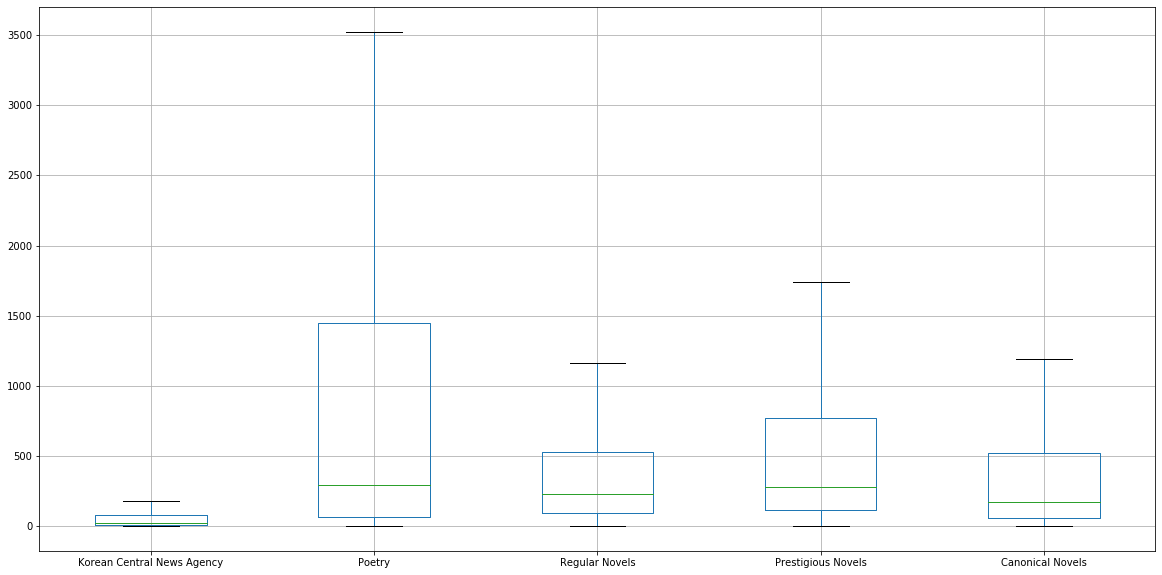

In [368]:
%matplotlib inline
df.boxplot(figsize = (20, 10), showfliers=False)

In [302]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df.describe()

,Korean Central News Agency,Poetry,Regular Novels,Prestigious Novels,Canonical Novels
count,10000.00000,10000.00000,10000.00000,9999.00000,10000.00000
mean,1484.08553,24364767025211729433748278601708497958511959238...,3.68812,1.22210,4486991.56380
std,96071.07508,24364767025211951414823574682659272894291026055...,245.33250,0.27763,320327398.20994
min,1.10887,1.07508,1.08997,1.09110,1.08933
25%,1.26102,1.14660,1.17008,1.16366,1.17501
50%,1.37151,1.19147,1.20166,1.19200,1.21177
75%,1.59900,1.27740,1.25116,1.23636,1.27539
max,9185310.45862,24364767025211729550720342230781094774046980542...,24534.47106,17.71895,25560735168.97106


In [303]:
from scipy import stats
from itertools import combinations
for a, b in list(combinations(df.columns, 2)):
    print(f'{a} : {b}')
    print(stats.ttest_ind(df[a],df[b]))

Korean Central News Agency : Poetry
Ttest_indResult(statistic=-1.0, pvalue=0.3173226074578517)
Korean Central News Agency : Regular Novels
Ttest_indResult(statistic=1.5409347492582066, pvalue=0.1233484897790222)
Korean Central News Agency : Prestigious Novels


C:\WPy64-3740\python-3.7.4.amd64\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\WPy64-3740\python-3.7.4.amd64\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\WPy64-3740\python-3.7.4.amd64\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Ttest_indResult(statistic=nan, pvalue=nan)
Korean Central News Agency : Canonical Novels
Ttest_indResult(statistic=-1.4002883617206645, pvalue=0.1614424988505722)
Poetry : Regular Novels
Ttest_indResult(statistic=1.0, pvalue=0.3173226074578517)
Poetry : Prestigious Novels
Ttest_indResult(statistic=nan, pvalue=nan)
Poetry : Canonical Novels
Ttest_indResult(statistic=1.0, pvalue=0.3173226074578517)
Regular Novels : Prestigious Novels
Ttest_indResult(statistic=nan, pvalue=nan)
Regular Novels : Canonical Novels
Ttest_indResult(statistic=-1.4007505760512682, pvalue=0.1613041889920176)
Prestigious Novels : Canonical Novels
Ttest_indResult(statistic=nan, pvalue=nan)


## Most cliche sentences

In [305]:
import numpy as np

def get_top_index(a, n):
    return np.argsort(a)[::-1][:n]

def get_flop_index(a, n):
    return np.argsort(a)[:n]

In [323]:
for corpus in list(final_results.keys()):
    print('TOP 10 Cliches for:', corpus)
    for index in get_top_index(final_results[corpus], 10):
        print(processed_corpus[corpus]['raw'][index])

TOP 10 Cliches for: Korean Central News Agency
경애하는 김정일장군님께서는 위대한 수령님께서 개척하신 주체의 혁명위업과 조국통일위업의 완성을 위한 투쟁을 현명하게 령도하고 계신다.
조선인민이 강성대국건설과 나라의 통일을 위한 투쟁에서 반드시 빛나는 승리를 이룩하리라는것을 확신한다.
나는 새 세기에 우리 두 나라사이에 존재하는 훌륭한 친선협조관계가 더욱 강화발전되리라고 믿으면서 나라의 번영을 위한 당신과 귀국인민의 사업에서 보다 큰 성과가 있을것을 축원합니다.
나는 새 세기에 우리 두 나라 사이의 친선협조관계가 앞으로 더욱 확대발전하리라고 확신하면서 나라의 안정과 번영을 위한 당신과 귀국인민의 사업에서 성과가 있을것을 충심으로 축원합니다.
모임에서는 위대한 령도자 김정일동지께 드리는 편지가 채택되였다.
토론회에서는 위대한 령도자 김정일동지께 드리는 편지가 채택되였다.
우리는 지난 날과 마찬가지로 앞으로도 나라의 발전과 조국통일을 위한 조선인민의 투쟁에 변함 없는 지지와 련대성을 보낼것이다.
위대한 사상리론가이시며 걸출한 정치가이신 김정일동지의 령도밑에 오늘 조선의 사회주의는 주체사상에 기초하여 힘차게 전진하고 있다.
참가자들은 김일성대원수님께 다함없는 경모의 정을 안고 삼가 인사를 드리였다.
모임에서는 위대한 령도자 김정일동지께 드리는 편지가 참가자들의 열광적인 박수속에 채택되였다.
TOP 10 Cliches for: Poetry
위대한 장군님
하나로 굳게 뭉쳐 우리 민족끼리
우리 장군님 얼마나 기뻐하시였던가
어버이수령님 경애하는 장군님
유구한 력사를 가진 이 땅우에서
하기에 그가 부르는 노래
이 땅의 모든것을 귀중히 여기며
시대와 력사 앞에
경애하는 수령을 위해
오늘도 전선에 계시는 장군님
TOP 10 Cliches for: Regular Novels
경애하는 장군님께서는 도당이 일을 잘하고있다고 평가하시고는 이렇게 말씀하시였다.
더이상 아무 말도 하고싶지 않았다.
이 모든 것을 생각해보는 리달춘은 머리를 들수 없었다.
우리

In [324]:
for corpus in list(final_results.keys()):
    print('TOP 10 Less Cliches for:', corpus)
    for index in get_flop_index(final_results[corpus], 10):
        print(processed_corpus[corpus]['raw'][index])

TOP 10 Less Cliches for: Korean Central News Agency
말리의 정당이 성명/조선 정부,정당,단체 호소문 지지.
백남순외상 흐르바쯔까외무상에게 축전.조선민주주의인민공화국 백남순외무상이 흐르바쯔까공화국 외무상 또니노 삐쭐라에게 축전을 보내였다.
그는 낵말 하나하나에 참기름을 치고 행동 하나하나에 진한 향수내를 피워 주위를 유혹하려고 한다.
에이피통신 책임편집인 미군만행진상을 뒤집는 주장을 정면반박.남조선의 제1라지오 가 전한데 의하면 에이피통신 책임편집인 죠나탄 월맨이 미군의 로근리대학살만행 진상을 뒤집으려는 미국어용언론지 유에스 뉴스 앤드 월드 리포트 의 주장을 정면으로 반박하여 성명을 발표하였다.
리기원동포의 고향은 인천시 강화군 량사면 교산리이다.
전인디아청년련맹 총서기 쏘니 텡가몸이 230만명을 대표하여,인디아전국청년대회 대표인 국회의원 개크 와드가 1,500만명을 대표하여,마로끄학생동맹 위원장 아브들라위 하캄이 25만5,000명을 대표하여 서명문에 수표하였다.
구조는 종전의 전동기처럼 고정자,회전자,동선 등이 없고 잘 계산된 몇개의 판대기가 전부이다.
그는 현재 서남아프리카인민조직 위원장,나미비아공화국 대통령,나미비아방위군 총사령관을 겸하고 있다.
캄보쟈 물리나까 및 자유를 위한 크메르투사당대표단,적도기네민주당대표단,가이아나아메리인디안사업상,훌륭한 록색가이아나당 총비서,네팔전국회상원의장,네팔공산당(맑스-레닌주의) 중앙위원회 위원장과총비서,네팔로동자농민당 중앙위원회 위원장,네팔청년체육 및 문화성련합비서,꾸바녀성법률가 깐델라리아 로드리게스를 비롯한 여러 나라의 정계,사회계의 저명한 인사들이 해당 나라 주재 우리 나라대사관을 축하방문하고 경애하는 장군님의 초상화에 꽃바구니와 꽃다발을 증정하고 삼가 인사를 드리였다.
광주봉기의 잊을수 없는 최후의 밤/의거자.
TOP 10 Less Cliches for: Poetry
한가지 결정 -
망국노설음
에헤요 황금가을 불러오세
우로 봣!
어이 해방자란 말과
부두가의 잔파도도
아, 민족작